# Detecting Early Stage Knee Osteoarthritis Using Deep Transfer Learning
### By Lokesh Meesala (001078109)

In [1]:
import os
import random
import pickle
import glob
import json
import shutil
import pathlib
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet152_preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from keras.preprocessing import image


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input 
import keras.backend as K

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def analyse_incorrect(actual, pred, results_df, data_dir):
    ## Used for analysing incorrect results
    print('Actual', actual, 'Pred', pred)
    incorrect_res = results_df[(results_df['Actuals'] == actual) & (results_df['Preds'] == pred)]
    for file_name in incorrect_res["File"].values:
        print(file_name)
        plt.imshow(cv2.imread(data_dir+file_name))
        plt.show()

def draw_confusion_matrix(actual, pred):
    ## Used to Plot Confusion Matrix
    cm = confusion_matrix(actual, pred)
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Reds', cbar=False)       
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print(f1_score(actual, pred, average="micro"))
    

def del_aug_data(data_dir):
    ## Deletes Augmented Data. Used to start with original data only.
    path = pathlib.Path(data_dir)
    shutil.rmtree(path, ignore_errors=True)

def get_data(train_path, test_path, val_path, target_labels):
    ## Used to read the data from the path and returns them as Dataframes
    train_data = glob.glob("**/*.png", root_dir=train_path, recursive=True)
    test_data = glob.glob("**/*.png", root_dir=test_path, recursive=True)
    val_data = glob.glob("**/*.png", root_dir=val_path, recursive=True)
    train_df = pd.DataFrame({"images":train_data})
    train_df['target_label'] = train_df.images.apply(lambda x: target_labels[int(x.split('\\')[0])])
    test_df = pd.DataFrame({"images":test_data})
    test_df['target_label'] = test_df.images.apply(lambda x: target_labels[int(x.split('\\')[0])])
    val_df = pd.DataFrame({"images":val_data})
    val_df['target_label'] = val_df.images.apply(lambda x: target_labels[int(x.split('\\')[0])])
    
    print(f"Number of Images in train {train_df.shape[0]}")
    print(f"Target Class Distribution in train {train_df.target_label.value_counts()} \n")    
    print(f"Number of Images in test {test_df.shape[0]}")
    print(f"Target Class Distribution in test {test_df.target_label.value_counts()} \n")    
    print(f"Number of Images in val {val_df.shape[0]}")
    print(f"Target Class Distribution in val {val_df.target_label.value_counts()} \n")  
    
    return train_df, test_df, val_df


def augment_dataset(data_df, data_dir, image_size, thresh):
    ## Selective Augmentation function, It is used to add new augmented images based on the threshold.
    
    ## Keras Image Data Generator
    generator = ImageDataGenerator(
        rotation_range=10,
        height_shift_range=0.15,
        horizontal_flip=True,
        vertical_flip=False,
        brightness_range=(0.2,0.5),
        fill_mode='nearest')
    
    ## Grouping by Target Label
    target_groups = data_df.groupby('target_label')
    target_label_counts = list(data_df['target_label'].value_counts().items())
    target_label_counts.sort()
    max_count = target_label_counts[0][1]
    
    ## Loop through each target group and check if the number of images are atleast the given threshold.
    ## If not, required number of images are added.
    for target, count in target_label_counts[1:]:
        group = target_groups.get_group(target)
        req_count = int(max_count*thresh) - count
        aug_dir = data_dir+"/"+target.split(":")[0]+"/aug"
        if not os.path.exists(aug_dir): os.mkdir(aug_dir)
        augmented_image_gen = generator.flow_from_dataframe(group,directory=data_dir, x_col='images', y_col=None, 
                                                            target_size=image_size,
                                                        class_mode=None, batch_size=1, shuffle=False, 
                                                        save_to_dir=aug_dir, save_prefix='aug', color_mode='rgb',
                                                        save_format='png')
        print(f"Adding {req_count} images to {aug_dir}")
        while req_count > 0:
            images=next(augmented_image_gen)            
            req_count -= len(images)
        max_count = int(max_count*thresh)


def create_data_gen(data_df, data_dir, data_gen, image_size, batch_size, shuffle):
    ## Function to create a Data Generator
    data = data_gen.flow_from_dataframe(data_df,data_dir, 
                                          x_col='images', y_col="target_label",
                                          target_size=image_size,
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          color_mode='rgb',
                                          shuffle=shuffle,
                                          seed = 123)
    return data


def get_cm_plot(y_true, y_pred, title, target_labels, figsize=(8, 8)):
    ## Function to return Confusion Matrix pplot, without plt.show()
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Reds', xticklabels=target_labels, yticklabels=target_labels, cbar=False)   
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    return plt


def run_prediction_save_metrics(model, data_gen, title, plot_metrics=False, return_preds=True):
    ## Fucntion get the predictions and Save the Evaluation Metrics.
    evaluation_dict = {}
    y_pred_scores = model.predict(data_gen)
    y_pred = y_pred_scores.argmax(axis=1)
    y_true = data_gen.labels
    targets = data_gen.class_indices.keys()

    if plot_metrics:
        plt = get_cm_plot(y_true, y_pred, title, targets, figsize=(3,3))
        plt.show()
        plt.close()
    
    
    # Computing the Evaulation metric scores.
    curr_f1_score = round(f1_score(y_pred, y_true, average='weighted'),3)
    curr_precision_score = round(precision_score(y_pred, y_true, average='weighted'), 3)
    curr_recall_score = round(recall_score(y_pred, y_true, average='weighted'), 3)
    curr_accuracy_score = round(accuracy_score(y_pred, y_true), 3)

    # Display the computed Evaulation metric scores.
    print(f"F1 Score {curr_f1_score}")
    print(f"Precision Score {curr_precision_score}")
    print(f"Recall Score {curr_recall_score}")
    print(f"Accuracy Score {curr_accuracy_score}")
    print(f"Classification Metrics \n{classification_report(y_pred, y_true)}")

    # Return the computed Evaulation metric scores.
    evaluation_dict.update({"f1_score" : curr_f1_score,
            "precision_score" : curr_precision_score,
            "recall_score" : curr_recall_score,
            "accuracy_score": curr_accuracy_score})
    
    if return_preds: 
        evaluation_dict["y_pred"] = y_pred
        evaluation_dict["y_true"] = y_true
    evaluation_dict["title"] = title
        
    return evaluation_dict


def create_model(transfer_model, image_size, num_classes, new_layers_list, freeze_layers=True, chkp_weights=None):
    ## Function to create the model, 
    ## It Takes the Transfer Learning Model and Fine Tuning Layers List as input and crease a model.
    
    base_model = transfer_model(input_shape=tuple(image_size + [3]),
                            include_top=False,
                            weights='imagenet'
                           )
    
    if freeze_layers:
        for layer in base_model.layers:
            layer.trainable = False  
    
    input_layer = base_model.input
    x = Flatten()(base_model.output)
    
    for each_layer in new_layers_list:
        x = each_layer(x)
        
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(input_layer, output_layer)
    
    if chkp_weights: model.load_weights(chkp_weights)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def fit_model(model, tr_data, vl_data, epochs, callbacks, iter_training = False, class_weight=None):
    ## Function to Fit the model
    hist = model.fit(tr_data,
          epochs=epochs,
          validation_data=vl_data,
          callbacks=callbacks,
          verbose=2,class_weight=class_weight)
    return model,hist


def fit_model_iterative(model, tr_data, vl_data, ts_data, epochs_per_iters, new_layers_count, layers_to_unfreeze, callbacks):
    ## Fucntion to fit the model iteratively.
    iters = {}
    
    ## First Layer to Unfreeze, It will be the last layer in transfer learning block.
    start_layer = -new_layers_count-3
    while layers_to_unfreeze >= 0:
        # Check if the layers to unfreeze threshold is reached.
        print(layers_to_unfreeze)
        print(f"Checking {model.layers[start_layer].name} Layer")
        if model.layers[start_layer].count_params() != 0:
            ## CHeck if layer has params, We want to unfreeze only trainable layers.
            print(f"Releasing {model.layers[start_layer].name} Layer")
            model.layers[start_layer].trainable = True
            hist = model.fit(tr_data,
                            epochs=epochs_per_iters,
                            validation_data=vl_data,
                            callbacks=callbacks,
                            verbose=2)
            
              
            ## Check the Metrics
            train_preds = model.predict(tr_data)
            val_preds = model.predict(vl_data)
            test_preds = model.predict(ts_data)
            
            train_f1_score = round(f1_score(tr_data.labels,train_preds.argmax(axis=1),average='weighted'), 3)
            val_f1_score =  round(f1_score(vl_data.labels,val_preds.argmax(axis=1),average='weighted'), 3)
            test_f1_score =  round(f1_score(ts_data.labels,test_preds.argmax(axis=1),average='weighted'), 3)
            draw_confusion_matrix(ts_data.labels, test_preds.argmax(axis=1))

            iters[model.layers[start_layer].name] = {
                     "params":hist.params, 
                     "history":hist.history, 
                     "train_f1_score":train_f1_score, 
                     "val_f1_score": val_f1_score,
                     "test_f1_score": test_f1_score
                    }
            
            print("train f1_score", train_f1_score)
            print("val f1_score", val_f1_score)
            print("test f1_score", test_f1_score)

            layers_to_unfreeze -= 1
            print(f"Layers left to be released {layers_to_unfreeze}")
        start_layer -= 1

    return model, iters

def save_exp(save_dir, exp_id, model, desc, eval_dict, targets, model_name=None, training_hist=None):
    ## Save the experiments, Model, Historay and plots.
    p = os.path.join(save_dir,exp_id+'/')
    if not os.path.exists(p): os.mkdir(p)
        
    cm_plot = get_cm_plot(eval_dict['y_true'], eval_dict['y_pred'], eval_dict['title'], targets)
    
    temp = eval_dict.pop('y_pred', None)
    temp = eval_dict.pop('y_true', None)
    
    cm_plot.savefig(p+eval_dict['title']+".png", dpi=800, bbox_inches="tight", pad_inches=0.5)
    cm_plot.close()
    
    eval_dict['description'] = desc


    if model_name: 
        model.save(p+model_name+".h5")
        
        hist = {
            "params":training_hist.params, 
            "history":training_hist.history}

    
        with open(p+model_name+'_hist.pkl', 'wb') as handle:
            pickle.dump(hist, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open(p+eval_dict['title']+".json", "w") as outfile:
        json.dump(eval_dict, outfile, indent=4)
    

## Parameters and Paths

In [3]:
data_dir = "kneeKL224/"
exp_dir = "experiments/"
train_dir = os.path.join(data_dir,'train')
test_dir = os.path.join(data_dir,'test')
val_dir = os.path.join(data_dir,'val')
target_labels=['0:Healthy', '1:Doubtful', '2:Minimal', '3:Moderate', '4:Severe']

NUM_CLASSES = 5
IMAGE_SIZE=[224, 224]
BATCH_SIZE= 64

#### Delete Any previously Augmented Data

In [4]:
for i in range(5):
    del_aug_data(train_dir+"/"+str(i)+"/aug")
    del_aug_data(val_dir+"/"+str(i)+"/aug")

### Create Dataframes from Paths

In [5]:
train_df, test_df, val_df = get_data(train_dir, test_dir, val_dir, target_labels)
class_weights = compute_class_weight('balanced', classes=target_labels, y=train_df.target_label.values)
class_weight_dict = dict(enumerate(class_weights))

Number of Images in train 5778
Target Class Distribution in train target_label
0:Healthy     2286
2:Minimal     1516
1:Doubtful    1046
3:Moderate     757
4:Severe       173
Name: count, dtype: int64 

Number of Images in test 1656
Target Class Distribution in test target_label
0:Healthy     639
2:Minimal     447
1:Doubtful    296
3:Moderate    223
4:Severe       51
Name: count, dtype: int64 

Number of Images in val 826
Target Class Distribution in val target_label
0:Healthy     328
2:Minimal     212
1:Doubtful    153
3:Moderate    106
4:Severe       27
Name: count, dtype: int64 



### Augment Train Data

In [6]:
augment_dataset(train_df, train_dir, [224, 224], thresh=0.70)

Found 1046 validated image filenames.
Adding 554 images to kneeKL224/train/1/aug
Found 1516 validated image filenames.
Adding -396 images to kneeKL224/train/2/aug
Found 757 validated image filenames.
Adding 27 images to kneeKL224/train/3/aug
Found 173 validated image filenames.
Adding 375 images to kneeKL224/train/4/aug


### Augment Validation Data

In [7]:
augment_dataset(val_df, val_dir, [224, 224], thresh=0.70)

Found 153 validated image filenames.
Adding 76 images to kneeKL224/val/1/aug
Found 212 validated image filenames.
Adding -52 images to kneeKL224/val/2/aug
Found 106 validated image filenames.
Adding 6 images to kneeKL224/val/3/aug
Found 27 validated image filenames.
Adding 51 images to kneeKL224/val/4/aug


### Create Dataframes with New Augmented Data

In [8]:
new_train_df, new_test_df, new_val_df = get_data(train_dir, test_dir, val_dir, target_labels)

Number of Images in train 6734
Target Class Distribution in train target_label
0:Healthy     2286
1:Doubtful    1600
2:Minimal     1516
3:Moderate     784
4:Severe       548
Name: count, dtype: int64 

Number of Images in test 1656
Target Class Distribution in test target_label
0:Healthy     639
2:Minimal     447
1:Doubtful    296
3:Moderate    223
4:Severe       51
Name: count, dtype: int64 

Number of Images in val 959
Target Class Distribution in val target_label
0:Healthy     328
1:Doubtful    229
2:Minimal     212
3:Moderate    112
4:Severe       78
Name: count, dtype: int64 



### Create Data Generators

In [9]:
# Create the Generators
train_data_gen = ImageDataGenerator(preprocessing_function=resnet152_preprocess_input,
                              rotation_range=5,
                              height_shift_range=0.5,
                              horizontal_flip=True,
                              vertical_flip=False,
                              fill_mode='nearest')

val_test_data_gen = ImageDataGenerator(preprocessing_function=resnet152_preprocess_input)

# Train data generator
train_data_w_aug = create_data_gen(new_train_df, train_dir, train_data_gen, IMAGE_SIZE, BATCH_SIZE, shuffle=True)
train_data_wo_aug = create_data_gen(train_df, train_dir, train_data_gen, IMAGE_SIZE, BATCH_SIZE, shuffle=False)

# Validation data generator
val_data_w_aug = create_data_gen(new_val_df, val_dir, val_test_data_gen, IMAGE_SIZE, BATCH_SIZE, shuffle=False)
val_data_wo_aug = create_data_gen(val_df, val_dir, val_test_data_gen, IMAGE_SIZE, BATCH_SIZE, shuffle=False)

# Test data generator
test_data = create_data_gen(new_test_df, test_dir, val_test_data_gen, IMAGE_SIZE, BATCH_SIZE, shuffle = False)

Found 6734 validated image filenames belonging to 5 classes.
Found 5778 validated image filenames belonging to 5 classes.
Found 959 validated image filenames belonging to 5 classes.
Found 826 validated image filenames belonging to 5 classes.
Found 1656 validated image filenames belonging to 5 classes.


#### Parameters to Save the Experiments

In [10]:
EXP_ID = '04_28_11_B64_AUG_TR_70_TS_70'
DESC = """Selective Augmentation;
RESNET152;
tr 0.7 ts 0.7; 
reducelr factor 0.2 pat 3;
batch_size 64
epochs 100
Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
    Dropout(0.3),
    Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
    Dropout(0.3),
    Dense(32,activation='relu'), 
    Dense(16,activation='relu')
"""
p = os.path.join(exp_dir,EXP_ID+'/')
os.makedirs(p+"/checkpoint", exist_ok=True)
checkpoint_filepath = p+"/checkpoint/weights-best-{epoch:02d}-{val_loss:.2f}.hdf5"

In [11]:
new_layers_list = [
    Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
    Dropout(0.3),
    Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
    Dropout(0.3),
    Dense(32,activation='relu'), 
    Dense(16,activation='relu')
]

### Create the model
model = create_model(ResNet152V2, IMAGE_SIZE, NUM_CLASSES, new_layers_list, freeze_layers=True, chkp_weights=None)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_loss',
                                            save_best_only=True)

## Fit the Model

In [ ]:
model,hist = fit_model(model, train_data_w_aug, val_data_w_aug, epochs=100, callbacks=[reduce_lr, early_stopping, model_checkpoint_callback],
                      class_weight=class_weight_dict)

## Get Plots and Metrics

In [ ]:
val_eval_dict = run_prediction_save_metrics(model,val_data_wo_aug,title="validation", plot_metrics=True, return_preds=True)
train_eval_dict = run_prediction_save_metrics(model,train_data_wo_aug,title="train", plot_metrics=True, return_preds=True)
test_eval_dict = run_prediction_save_metrics(model,test_data,title="test", plot_metrics=True, return_preds=True)

## Save the Experiments

In [ ]:
save_exp(exp_dir, EXP_ID, model, DESC, test_eval_dict, target_labels,
         model_name=EXP_ID+"_v2", training_hist=hist)

save_exp(exp_dir, EXP_ID, model, DESC, train_eval_dict, target_labels)

save_exp(exp_dir, EXP_ID, model, DESC, val_eval_dict, target_labels)

# Load Best Checkpoint

13/13 [==============================] - 44s 3s/step


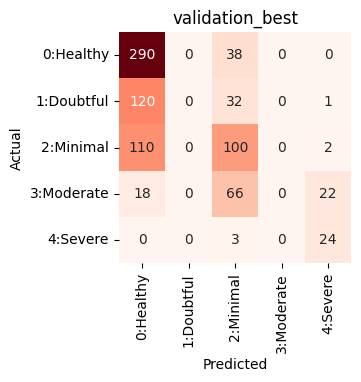

F1 Score 0.602
Precision Score 0.765
Recall Score 0.501
Accuracy Score 0.501
Classification Metrics 
              precision    recall  f1-score   support

           0       0.88      0.54      0.67       538
           1       0.00      0.00      0.00         0
           2       0.47      0.42      0.44       239
           3       0.00      0.00      0.00         0
           4       0.89      0.49      0.63        49

    accuracy                           0.50       826
   macro avg       0.45      0.29      0.35       826
weighted avg       0.77      0.50      0.60       826

91/91 [==============================] - 217s 2s/step


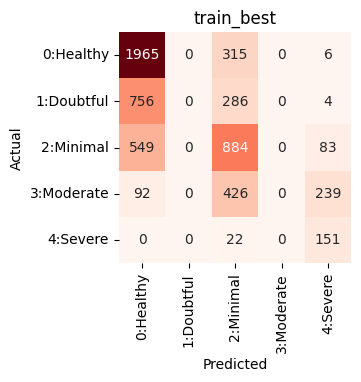

F1 Score 0.615
Precision Score 0.768
Recall Score 0.519
Accuracy Score 0.519
Classification Metrics 
              precision    recall  f1-score   support

           0       0.86      0.58      0.70      3362
           1       0.00      0.00      0.00         0
           2       0.58      0.46      0.51      1933
           3       0.00      0.00      0.00         0
           4       0.87      0.31      0.46       483

    accuracy                           0.52      5778
   macro avg       0.46      0.27      0.33      5778
weighted avg       0.77      0.52      0.61      5778

26/26 [==============================] - 65s 3s/step


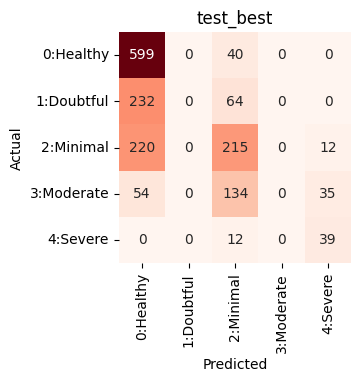

F1 Score 0.62
Precision Score 0.8
Recall Score 0.515
Accuracy Score 0.515
Classification Metrics 
              precision    recall  f1-score   support

           0       0.94      0.54      0.69      1105
           1       0.00      0.00      0.00         0
           2       0.48      0.46      0.47       465
           3       0.00      0.00      0.00         0
           4       0.76      0.45      0.57        86

    accuracy                           0.52      1656
   macro avg       0.44      0.29      0.35      1656
weighted avg       0.80      0.52      0.62      1656



In [12]:
best_chkp_point = "best_checkpoint/weights-best-72-1.18.hdf5"
model = create_model(ResNet152V2, IMAGE_SIZE, NUM_CLASSES, new_layers_list, freeze_layers=True, chkp_weights=best_chkp_point, )

DESC = DESC+"|best chkpoint"
EXP_ID = "final_best"

val_eval_dict = run_prediction_save_metrics(model,val_data_wo_aug,title="validation_best", plot_metrics=True, return_preds=True)
train_eval_dict = run_prediction_save_metrics(model,train_data_wo_aug,title="train_best", plot_metrics=True, return_preds=True)
test_eval_dict = run_prediction_save_metrics(model,test_data,title="test_best", plot_metrics=True, return_preds=True)

# Analyze all the experiment results

In [13]:
exp_data = []

for p in glob.glob("**/*.json", root_dir=exp_dir, recursive=True):
    f = open(exp_dir+p)
    exp_dict = json.load(f)
    exp_dict['exp_id'] = p.split("\\")[0]
    exp_data.append(exp_dict)

res_df = pd.json_normalize(exp_data)
final_res_df  = res_df.groupby(['exp_id','title']).agg({'f1_score': 'first',
                                       'precision_score':'first',
                                       'recall_score': 'first',
                                       'accuracy_score': 'first',
                                       'description':'first'})

final_res_df.description = final_res_df.description.apply(lambda x: x.strip())

final_res_df

f1_score   
exp_id                                    title                       
04_19_1                                   test                0.432  \
                                          train               0.187   
                                          validation          0.462   
04_19_2                                   test                0.488   
                                          train               0.200   
...                                                             ...   
04_27_4_B64_AUG_TR_70_TS_70_BEST_TS_62_f1 train               0.615   
                                          validation          0.603   
final_best                                test_best           0.620   
                                          train_best          0.618   
                                          validation_best     0.602   

                                                           precision_score   
exp_id                                    title                              
04_19_1                                   test                       0.441  \
                                          train                      0.204   
                                          validation                 0.473   
04_19_2                                   test                       0.472   
                                          train                      0.201   
...                                                                    ...   
04_27_4_B64_AUG_TR_70_TS_70_BEST_TS_62_f1 train                      0.763   
                                          validation                 0.757   
final_best                                test_best                  0.800   
                                          train_best                 0.773   
                                          validation_best            0.765   

                                                           recall_score   
exp_id                                    title                           
04_19_1                                   test                    0.516  \
                                          train                   0.205   
                                          validation              0.494   
04_19_2                                   test                    0.513   
                                          train                   0.201   
...                                                                 ...   
04_27_4_B64_AUG_TR_70_TS_70_BEST_TS_62_f1 train                   0.520   
                                          validation              0.504   
final_best                                test_best               0.515   
                                          train_best              0.522   
                                          validation_best         0.501   

                                                           accuracy_score   
exp_id                                    title                             
04_19_1                                   test                      0.539  \
                                          train                     0.313   
                                          validation                0.540   
04_19_2                                   test                      0.521   
                                          train                     0.282   
...                                                                   ...   
04_27_4_B64_AUG_TR_70_TS_70_BEST_TS_62_f1 train                     0.520   
                                          validation                0.504   
final_best                                test_best                 0.515   
                                          train_best                0.522   
                                          validation_best           0.501   

                                                                                                 description  
exp_id                         